<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/ConvolutionNerualNetwork/classify_spam_using_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D CNN으로 스팸 메일 분류

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [46]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [47]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [48]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [49]:
data.drop_duplicates(subset=['v2'], inplace=True)
len(data)

5169

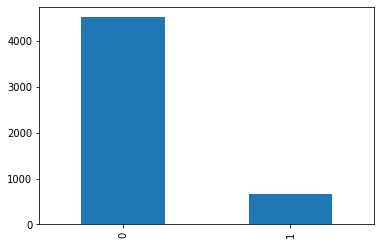

In [50]:
data['v1'].value_counts().plot(kind='bar')

In [51]:
x_data = data['v2']
y_data = data['v1']

In [52]:
# stratify 인자는 test_size=0.2 의 기준이 y_data가 되도록 하여 레이블이 고르게 분포하도록 함
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

토큰화

In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train_encoded = tokenizer.texts_to_sequences(x_train)
print(x_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [54]:
word_to_index = tokenizer.word_index

In [55]:
threshold = 2
total_cnt = len(word_to_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if value<threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq/ total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수 : 4337
단어 집합에서 희귀 단어의 비율 :  55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 6.65745644331875


In [56]:
vocab_size = len(word_to_index) + 1

In [57]:
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  7822


In [58]:
print('메일의 최대 길이 : ', max(len(v) for v in x_train_encoded))

메일의 최대 길이 :  189


In [59]:
max_len = 189
x_train_padded = pad_sequences(x_train_encoded, maxlen=max_len)
print('훈련 데이터의 크기(shape) : ', x_train_padded.shape)

훈련 데이터의 크기(shape) :  (4135, 189)


1D CNN으로 모델 설계

In [60]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 32
dropout_ratio = 0.3
num_filters = 32
kernel_size = 5

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
51/52 [============================>.] - ETA: 0s - loss: 0.4962 - acc: 0.8438
Epoch 00001: val_acc improved from -inf to 0.87787, saving model to best_model.h5
52/52 [==============================] - 4s 54ms/step - loss: 0.4949 - acc: 0.8440 - val_loss: 0.3704 - val_acc: 0.8779
Epoch 2/10
51/52 [============================>.] - ETA: 0s - loss: 0.3705 - acc: 0.8732
Epoch 00002: val_acc did not improve from 0.87787
52/52 [==============================] - 3s 48ms/step - loss: 0.3713 - acc: 0.8727 - val_loss: 0.3434 - val_acc: 0.8779
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.2938 - acc: 0.8845
Epoch 00003: val_acc improved from 0.87787 to 0.94921, saving model to best_model.h5
52/52 [==============================] - 3s 50ms/step - loss: 0.2938 - acc: 0.8845 - val_loss: 0.2230 - val_acc: 0.9492
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.1516 - acc: 0.9544
Epoch 00004: val_acc improved from 0.94921 to 0.97219, saving model

In [61]:
x_test_encoded = tokenizer.texts_to_sequences(x_test)
x_test_padded = pad_sequences(x_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test_padded, y_test)[1]))

33/33 [==============================] - 0s 7ms/step - loss: 0.0668 - acc: 0.9836

 테스트 정확도: 0.9836


In [69]:
def prediction(sentence):
  sentence = tokenizer.texts_to_sequences([sentence])
  sentence = pad_sequences(sentence, maxlen=max_len)
  predict = float(model.predict(sentence))
  print(predict)